In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [51]:
df = pd.read_csv('data/data/daily_min_temp.csv', index_col = 'Date', parse_dates= ['Date'])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


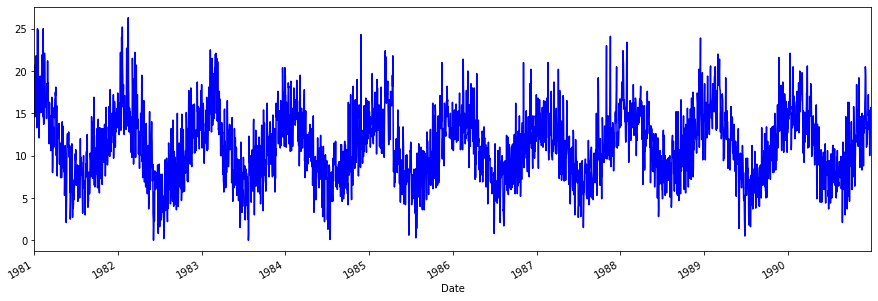

In [52]:
df.Temp.plot(figsize = (15, 5), color = 'b')

# Dataset Splitting

In [53]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle = False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset and Dataloader

In [54]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import TensorDataset, DataLoader

In [55]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, 'Temp', seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, 'Temp', seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Architecture & Configuration

In [56]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout = dropout, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc (x)
        return x, hidden

In [57]:
config = set_config({
    'input_size': train_set.n_feature,
    'seq_len': train_set.n_seq,
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0,
    'output_size': 1,    
})

# Training Preparation

In [58]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/rnn")

# Training

In [59]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 132.8761 | Test_cost  = 118.2131 | 




Epoch     2
Train_cost  = 99.0592 | Test_cost  = 89.2492 | 




Epoch     3
Train_cost  = 75.0455 | Test_cost  = 70.2946 | 




Epoch     4
Train_cost  = 60.1121 | Test_cost  = 59.0925 | 




Epoch     5
Train_cost  = 51.1612 | Test_cost  = 51.7027 | 




Epoch     6
Train_cost  = 44.9031 | Test_cost  = 45.9519 | 




Epoch     7
Train_cost  = 39.9052 | Test_cost  = 41.1532 | 




Epoch     8
Train_cost  = 35.7288 | Test_cost  = 37.0825 | 




Epoch     9
Train_cost  = 32.2089 | Test_cost  = 33.6249 | 




Epoch    10
Train_cost  = 29.2466 | Test_cost  = 30.6961 | 




Epoch    11
Train_cost  = 26.7649 | Test_cost  = 28.2259 | 




Epoch    12
Train_cost  = 24.6980 | Test_cost  = 26.1529 | 




Epoch    13
Train_cost  = 22.9880 | Test_cost  = 24.4228 | 




Epoch    14
Train_cost  = 21.5834 | Test_cost  = 22.9870 | 




Epoch    15
Train_cost  = 20.4386 | Test_cost  = 21.8024 | 




Epoch    16
Train_cost  = 19.5130 | Test_cost  = 20.8307 | 




Epoch    17
Train_cost  = 18.7709 | Test_cost  = 20.0382 | 




Epoch    18
Train_cost  = 18.1809 | Test_cost  = 19.3952 | 




Epoch    19
Train_cost  = 17.7157 | Test_cost  = 18.8762 | 




Epoch    20
Train_cost  = 17.3520 | Test_cost  = 18.4590 | 


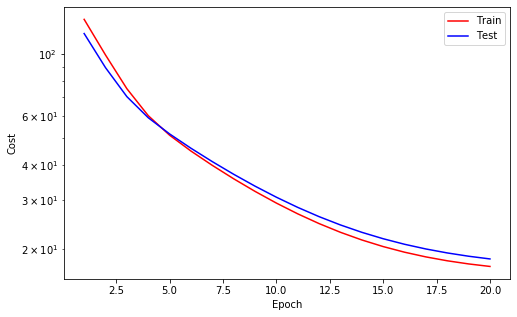



Epoch    21
Train_cost  = 17.0699 | Test_cost  = 18.1249 | 




Epoch    22
Train_cost  = 16.8528 | Test_cost  = 17.8582 | 




Epoch    23
Train_cost  = 16.6868 | Test_cost  = 17.6456 | 




Epoch    24
Train_cost  = 16.5606 | Test_cost  = 17.4763 | 




Epoch    25
Train_cost  = 16.4650 | Test_cost  = 17.3413 | 




Epoch    26
Train_cost  = 16.3925 | Test_cost  = 17.2335 | 




Epoch    27
Train_cost  = 16.3375 | Test_cost  = 17.1470 | 




Epoch    28
Train_cost  = 16.2952 | Test_cost  = 17.0770 | 




Epoch    29
Train_cost  = 16.2620 | Test_cost  = 17.0197 | 




Epoch    30
Train_cost  = 16.2350 | Test_cost  = 16.9719 | 




Epoch    31
Train_cost  = 16.2118 | Test_cost  = 16.9309 | 




Epoch    32
Train_cost  = 16.1902 | Test_cost  = 16.8940 | 




Epoch    33
Train_cost  = 16.1678 | Test_cost  = 16.8581 | 




Epoch    34
Train_cost  = 16.1415 | Test_cost  = 16.8187 | 




Epoch    35
Train_cost  = 16.1048 | Test_cost  = 16.7654 | 




Epoch    36
Train_cost  = 16.0418 | Test_cost  = 16.6704 | 




Epoch    37
Train_cost  = 15.9063 | Test_cost  = 16.4495 | 




Epoch    38
Train_cost  = 15.5378 | Test_cost  = 15.8097 | 




Epoch    39
Train_cost  = 14.6707 | Test_cost  = 15.2895 | 




Epoch    40
Train_cost  = 13.8938 | Test_cost  = 14.1797 | 


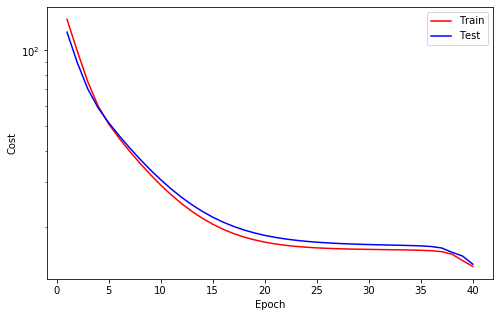



Epoch    41
Train_cost  = 13.1064 | Test_cost  = 13.4413 | 




Epoch    42
Train_cost  = 12.4451 | Test_cost  = 12.6687 | 




Epoch    43
Train_cost  = 11.8252 | Test_cost  = 11.8453 | 




Epoch    44
Train_cost  = 11.2281 | Test_cost  = 11.2556 | 




Epoch    45
Train_cost  = 10.8068 | Test_cost  = 10.7854 | 




Epoch    46
Train_cost  = 10.4642 | Test_cost  = 10.3186 | 




Epoch    47
Train_cost  = 10.0834 | Test_cost  = 9.9273 | 




Epoch    48
Train_cost  = 9.7598 | Test_cost  = 9.5784 | 




Epoch    49
Train_cost  = 9.5091 | Test_cost  = 9.2558 | 




Epoch    50
Train_cost  = 9.2871 | Test_cost  = 8.9687 | 




Epoch    51
Train_cost  = 9.0754 | Test_cost  = 8.7245 | 




Epoch    52
Train_cost  = 8.8924 | Test_cost  = 8.5103 | 




Epoch    53
Train_cost  = 8.7406 | Test_cost  = 8.3145 | 




Epoch    54
Train_cost  = 8.6026 | Test_cost  = 8.1328 | 




Epoch    55
Train_cost  = 8.4663 | Test_cost  = 7.9675 | 




Epoch    56
Train_cost  = 8.3362 | Test_cost  = 7.8180 | 




Epoch    57
Train_cost  = 8.2184 | Test_cost  = 7.6812 | 




Epoch    58
Train_cost  = 8.1115 | Test_cost  = 7.5530 | 




Epoch    59
Train_cost  = 8.0110 | Test_cost  = 7.4323 | 




Epoch    60
Train_cost  = 7.9150 | Test_cost  = 7.3200 | 


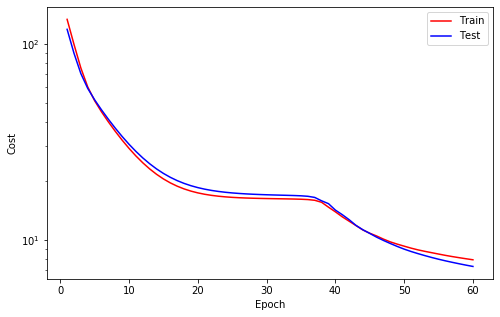



Epoch    61
Train_cost  = 7.8245 | Test_cost  = 7.2160 | 




Epoch    62
Train_cost  = 7.7405 | Test_cost  = 7.1192 | 




Epoch    63
Train_cost  = 7.6632 | Test_cost  = 7.0289 | 




Epoch    64
Train_cost  = 7.5918 | Test_cost  = 6.9442 | 




Epoch    65
Train_cost  = 7.5253 | Test_cost  = 6.8648 | 




Epoch    66
Train_cost  = 7.4633 | Test_cost  = 6.7903 | 




Epoch    67
Train_cost  = 7.4057 | Test_cost  = 6.7202 | 




Epoch    68
Train_cost  = 7.3521 | Test_cost  = 6.6543 | 




Epoch    69
Train_cost  = 7.3019 | Test_cost  = 6.5921 | 




Epoch    70
Train_cost  = 7.2548 | Test_cost  = 6.5334 | 




Epoch    71
Train_cost  = 7.2104 | Test_cost  = 6.4780 | 




Epoch    72
Train_cost  = 7.1686 | Test_cost  = 6.4256 | 




Epoch    73
Train_cost  = 7.1289 | Test_cost  = 6.3761 | 




Epoch    74
Train_cost  = 7.0914 | Test_cost  = 6.3294 | 




Epoch    75
Train_cost  = 7.0559 | Test_cost  = 6.2852 | 




Epoch    76
Train_cost  = 7.0222 | Test_cost  = 6.2434 | 




Epoch    77
Train_cost  = 6.9903 | Test_cost  = 6.2038 | 




Epoch    78
Train_cost  = 6.9599 | Test_cost  = 6.1663 | 




Epoch    79
Train_cost  = 6.9311 | Test_cost  = 6.1308 | 




Epoch    80
Train_cost  = 6.9037 | Test_cost  = 6.0970 | 


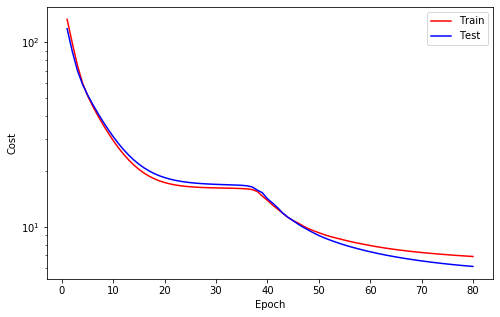



Epoch    81
Train_cost  = 6.8776 | Test_cost  = 6.0651 | 




Epoch    82
Train_cost  = 6.8527 | Test_cost  = 6.0347 | 




Epoch    83
Train_cost  = 6.8290 | Test_cost  = 6.0058 | 




Epoch    84
Train_cost  = 6.8065 | Test_cost  = 5.9783 | 




Epoch    85
Train_cost  = 6.7849 | Test_cost  = 5.9521 | 




Epoch    86
Train_cost  = 6.7643 | Test_cost  = 5.9272 | 




Epoch    87
Train_cost  = 6.7446 | Test_cost  = 5.9034 | 




Epoch    88
Train_cost  = 6.7258 | Test_cost  = 5.8806 | 




Epoch    89
Train_cost  = 6.7078 | Test_cost  = 5.8589 | 




Epoch    90
Train_cost  = 6.6905 | Test_cost  = 5.8381 | 




Epoch    91
Train_cost  = 6.6740 | Test_cost  = 5.8182 | 




Epoch    92
Train_cost  = 6.6581 | Test_cost  = 5.7991 | 




Epoch    93
Train_cost  = 6.6428 | Test_cost  = 5.7807 | 




Epoch    94
Train_cost  = 6.6282 | Test_cost  = 5.7630 | 




Epoch    95
Train_cost  = 6.6140 | Test_cost  = 5.7461 | 




Epoch    96
Train_cost  = 6.6004 | Test_cost  = 5.7297 | 




Epoch    97
Train_cost  = 6.5873 | Test_cost  = 5.7139 | 




Epoch    98
Train_cost  = 6.5747 | Test_cost  = 5.6987 | 




Epoch    99
Train_cost  = 6.5625 | Test_cost  = 5.6840 | 




Epoch   100
Train_cost  = 6.5507 | Test_cost  = 5.6697 | 


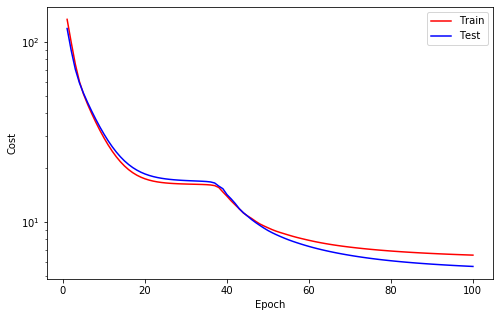



Epoch   101
Train_cost  = 6.5393 | Test_cost  = 5.6560 | 




Epoch   102
Train_cost  = 6.5283 | Test_cost  = 5.6426 | 




Epoch   103
Train_cost  = 6.5176 | Test_cost  = 5.6297 | 




Epoch   104
Train_cost  = 6.5073 | Test_cost  = 5.6172 | 




Epoch   105
Train_cost  = 6.4972 | Test_cost  = 5.6050 | 




Epoch   106
Train_cost  = 6.4875 | Test_cost  = 5.5932 | 




Epoch   107
Train_cost  = 6.4780 | Test_cost  = 5.5817 | 




Epoch   108
Train_cost  = 6.4688 | Test_cost  = 5.5705 | 




Epoch   109
Train_cost  = 6.4598 | Test_cost  = 5.5596 | 




Epoch   110
Train_cost  = 6.4510 | Test_cost  = 5.5491 | 




Epoch   111
Train_cost  = 6.4425 | Test_cost  = 5.5387 | 




Epoch   112
Train_cost  = 6.4342 | Test_cost  = 5.5287 | 




Epoch   113
Train_cost  = 6.4260 | Test_cost  = 5.5189 | 




Epoch   114
Train_cost  = 6.4181 | Test_cost  = 5.5094 | 




Epoch   115
Train_cost  = 6.4103 | Test_cost  = 5.5001 | 




Epoch   116
Train_cost  = 6.4027 | Test_cost  = 5.4910 | 




Epoch   117
Train_cost  = 6.3953 | Test_cost  = 5.4821 | 




Epoch   118
Train_cost  = 6.3880 | Test_cost  = 5.4735 | 




Epoch   119
Train_cost  = 6.3808 | Test_cost  = 5.4651 | 




Epoch   120
Train_cost  = 6.3738 | Test_cost  = 5.4568 | 


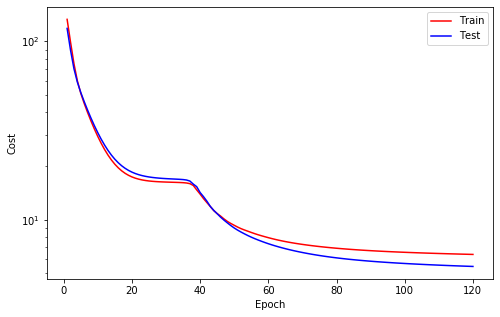



Epoch   121
Train_cost  = 6.3669 | Test_cost  = 5.4488 | 




Epoch   122
Train_cost  = 6.3602 | Test_cost  = 5.4409 | 




Epoch   123
Train_cost  = 6.3535 | Test_cost  = 5.4333 | 




Epoch   124
Train_cost  = 6.3470 | Test_cost  = 5.4258 | 




Epoch   125
Train_cost  = 6.3405 | Test_cost  = 5.4185 | 




Epoch   126
Train_cost  = 6.3342 | Test_cost  = 5.4114 | 




Epoch   127
Train_cost  = 6.3280 | Test_cost  = 5.4044 | 




Epoch   128
Train_cost  = 6.3219 | Test_cost  = 5.3976 | 




Epoch   129
Train_cost  = 6.3158 | Test_cost  = 5.3910 | 




Epoch   130
Train_cost  = 6.3099 | Test_cost  = 5.3845 | 




Epoch   131
Train_cost  = 6.3040 | Test_cost  = 5.3783 | 




Epoch   132
Train_cost  = 6.2982 | Test_cost  = 5.3721 | 




Epoch   133
Train_cost  = 6.2925 | Test_cost  = 5.3661 | 




Epoch   134
Train_cost  = 6.2869 | Test_cost  = 5.3603 | 




Epoch   135
Train_cost  = 6.2813 | Test_cost  = 5.3547 | 




Epoch   136
Train_cost  = 6.2759 | Test_cost  = 5.3492 | 




Epoch   137
Train_cost  = 6.2704 | Test_cost  = 5.3438 | 




Epoch   138
Train_cost  = 6.2651 | Test_cost  = 5.3386 | 




Epoch   139
Train_cost  = 6.2598 | Test_cost  = 5.3335 | 




Epoch   140
Train_cost  = 6.2546 | Test_cost  = 5.3286 | 


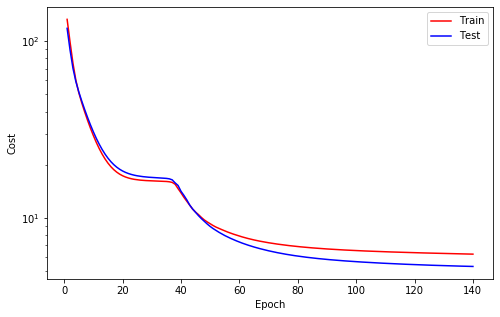



Epoch   141
Train_cost  = 6.2495 | Test_cost  = 5.3239 | 




Epoch   142
Train_cost  = 6.2444 | Test_cost  = 5.3193 | 




Epoch   143
Train_cost  = 6.2394 | Test_cost  = 5.3148 | 




Epoch   144
Train_cost  = 6.2345 | Test_cost  = 5.3105 | 




Epoch   145
Train_cost  = 6.2296 | Test_cost  = 5.3063 | 




Epoch   146
Train_cost  = 6.2248 | Test_cost  = 5.3023 | 




Epoch   147
Train_cost  = 6.2200 | Test_cost  = 5.2984 | 




Epoch   148
Train_cost  = 6.2153 | Test_cost  = 5.2946 | 




Epoch   149
Train_cost  = 6.2107 | Test_cost  = 5.2910 | 




Epoch   150
Train_cost  = 6.2061 | Test_cost  = 5.2875 | 




Epoch   151
Train_cost  = 6.2016 | Test_cost  = 5.2841 | 




Epoch   152
Train_cost  = 6.1971 | Test_cost  = 5.2809 | 




Epoch   153
Train_cost  = 6.1927 | Test_cost  = 5.2778 | 




Epoch   154
Train_cost  = 6.1883 | Test_cost  = 5.2748 | 




Epoch   155
Train_cost  = 6.1840 | Test_cost  = 5.2719 | 




Epoch   156
Train_cost  = 6.1798 | Test_cost  = 5.2691 | 




Epoch   157
Train_cost  = 6.1756 | Test_cost  = 5.2664 | 




Epoch   158
Train_cost  = 6.1715 | Test_cost  = 5.2639 | 




Epoch   159
Train_cost  = 6.1674 | Test_cost  = 5.2614 | 




Epoch   160
Train_cost  = 6.1634 | Test_cost  = 5.2590 | 


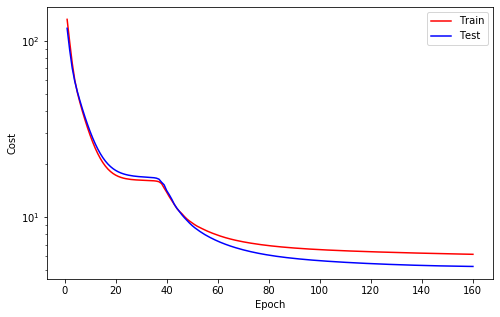



Epoch   161
Train_cost  = 6.1594 | Test_cost  = 5.2568 | 




Epoch   162
Train_cost  = 6.1555 | Test_cost  = 5.2546 | 




Epoch   163
Train_cost  = 6.1516 | Test_cost  = 5.2525 | 




Epoch   164
Train_cost  = 6.1478 | Test_cost  = 5.2504 | 




Epoch   165
Train_cost  = 6.1440 | Test_cost  = 5.2485 | 




Epoch   166
Train_cost  = 6.1402 | Test_cost  = 5.2466 | 




Epoch   167
Train_cost  = 6.1365 | Test_cost  = 5.2448 | 




Epoch   168
Train_cost  = 6.1329 | Test_cost  = 5.2431 | 




Epoch   169
Train_cost  = 6.1292 | Test_cost  = 5.2414 | 




Epoch   170
Train_cost  = 6.1257 | Test_cost  = 5.2398 | 




Epoch   171
Train_cost  = 6.1221 | Test_cost  = 5.2383 | 




Epoch   172
Train_cost  = 6.1186 | Test_cost  = 5.2368 | 




Epoch   173
Train_cost  = 6.1151 | Test_cost  = 5.2354 | 




Epoch   174
Train_cost  = 6.1116 | Test_cost  = 5.2340 | 




Epoch   175
Train_cost  = 6.1082 | Test_cost  = 5.2327 | 




Epoch   176
Train_cost  = 6.1047 | Test_cost  = 5.2314 | 




Epoch   177
Train_cost  = 6.1013 | Test_cost  = 5.2302 | 




Epoch   178
Train_cost  = 6.0980 | Test_cost  = 5.2291 | 




Epoch   179
Train_cost  = 6.0946 | Test_cost  = 5.2280 | 




Epoch   180
Train_cost  = 6.0912 | Test_cost  = 5.2269 | 


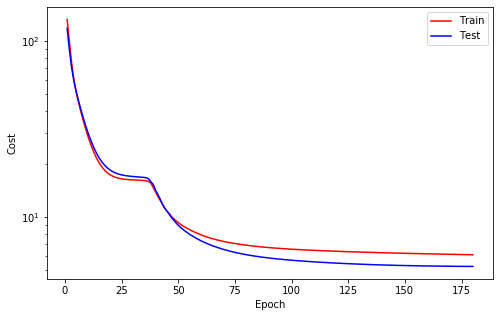



Epoch   181
Train_cost  = 6.0879 | Test_cost  = 5.2259 | 




Epoch   182
Train_cost  = 6.0845 | Test_cost  = 5.2250 | 




Epoch   183
Train_cost  = 6.0812 | Test_cost  = 5.2241 | 




Epoch   184
Train_cost  = 6.0779 | Test_cost  = 5.2233 | 




Epoch   185
Train_cost  = 6.0745 | Test_cost  = 5.2225 | 




Epoch   186
Train_cost  = 6.0712 | Test_cost  = 5.2217 | 




Epoch   187
Train_cost  = 6.0679 | Test_cost  = 5.2211 | 




Epoch   188
Train_cost  = 6.0646 | Test_cost  = 5.2204 | 




Epoch   189
Train_cost  = 6.0612 | Test_cost  = 5.2198 | 




Epoch   190
Train_cost  = 6.0579 | Test_cost  = 5.2193 | 




Epoch   191
Train_cost  = 6.0546 | Test_cost  = 5.2188 | 




Epoch   192
Train_cost  = 6.0512 | Test_cost  = 5.2184 | 




Epoch   193
Train_cost  = 6.0478 | Test_cost  = 5.2180 | 




Epoch   194
Train_cost  = 6.0445 | Test_cost  = 5.2176 | 




Epoch   195
Train_cost  = 6.0411 | Test_cost  = 5.2173 | 




Epoch   196
Train_cost  = 6.0377 | Test_cost  = 5.2170 | 




Epoch   197
Train_cost  = 6.0342 | Test_cost  = 5.2168 | 




Epoch   198
Train_cost  = 6.0308 | Test_cost  = 5.2166 | 




Epoch   199
Train_cost  = 6.0273 | Test_cost  = 5.2165 | 




Epoch   200
Train_cost  = 6.0238 | Test_cost  = 5.2164 | 


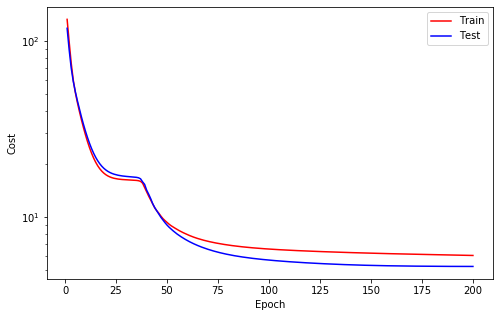



Epoch   201
Train_cost  = 6.0203 | Test_cost  = 5.2163 | 




Epoch   202
Train_cost  = 6.0168 | Test_cost  = 5.2163 | 




Epoch   203
Train_cost  = 6.0132 | Test_cost  = 5.2163 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2163




Epoch   204
Train_cost  = 6.0096 | Test_cost  = 5.2164 | 
==> EarlyStop patience =  2 | Best test_cost: 5.2163




Epoch   205
Train_cost  = 6.0060 | Test_cost  = 5.2164 | 
==> EarlyStop patience =  3 | Best test_cost: 5.2163




Epoch   206
Train_cost  = 6.0023 | Test_cost  = 5.2165 | 
==> EarlyStop patience =  4 | Best test_cost: 5.2163




Epoch   207
Train_cost  = 5.9986 | Test_cost  = 5.2167 | 
==> EarlyStop patience =  5 | Best test_cost: 5.2163
==> Execute Early Stopping at epoch: 207 | Best test_cost: 5.2163
==> Best model is saved at model/rnn


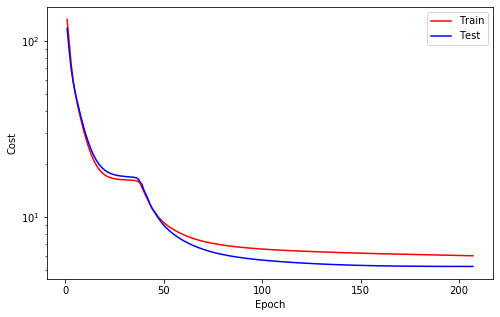

In [60]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [61]:
from utils import data4pred, pred4pred

In [67]:
train_forecast_set = TimeSeriesDataset(ts_train, 'Temp', 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, 'Temp', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Train')

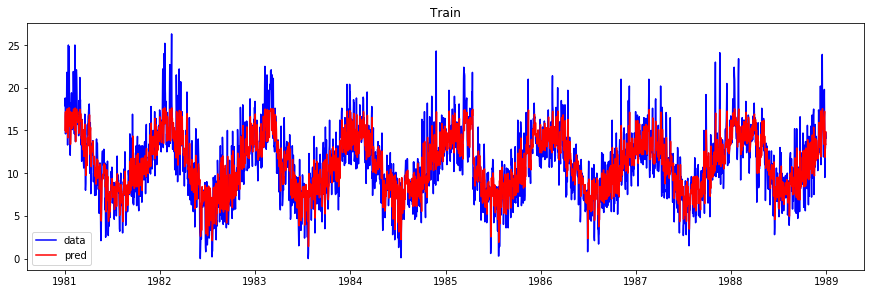

In [72]:
plt.figure(figsize =(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')


Text(0.5, 1.0, 'Test')

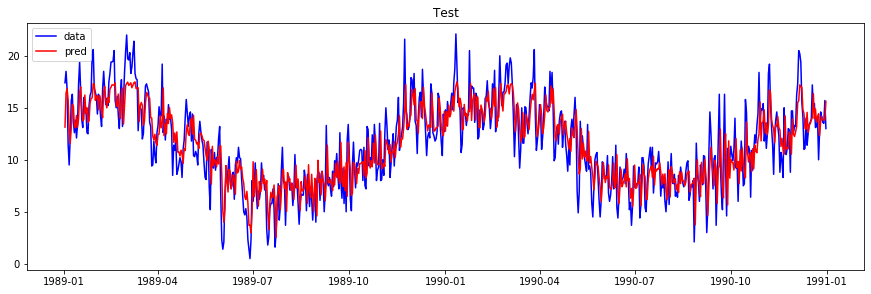

In [74]:
plt.figure(figsize =(15, 10))
plt.subplot(211)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

Text(0.5, 1.0, 'test')

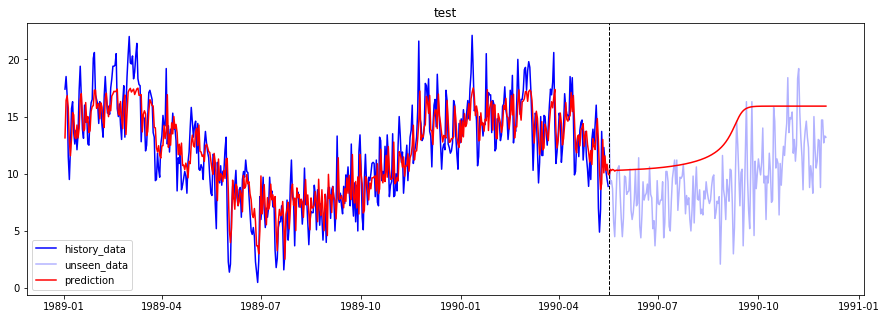

In [75]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title('test')